# Imports

In [9]:
import sys
sys.path.append("src/datasets")

import pandas as pd
import logging
from src.datasets.merge_movie_lens import merge_movie_lens
from src.datasets.imdb_management import ImdbSearcher
from src.datasets.extract_movielens_to_imdb_mapping import get_tconst_by_title
from src.datasets.augment_movielens import *

# Data preparation

## Select data

### Select data source

#### MovieLens 1M
[Расписать про то, зачем взяли этот датасет, вывести по несколько строчек с каждого .dat файла]

#### IMDB
[Максим тут]

### Select attributes and records

In [1]:
# TODO Maxim

## Clean data

In [3]:
# TODO Максим, распиши про преобразования (выкинуть половину IMDB)

## Construct data

#### Convert initial MovieLens' .dat files to .csv files and merge these .csv files

In [2]:
merge_movie_lens()

INFO:root:Converting movies file to .csv format...
INFO:root:Converting ratings file to .csv format...
INFO:root:Converting users file to .csv format...
INFO:root:Merging the dataframes...
INFO:root:Data is ready.


#### IMDB

In [3]:
# TODO Максим: напиши свою часть про IMDB

## Integrate data

### Matching IMDB titles to Movielens titles

Before augmenting the movielens dataset with IMDB titles we need to establish one-to-one correspondence between titles in these datasets. 

As soon as titles are written in a slightly different ways, some manual string processing was applyed. This includes removing the year from the title and moving articles "A", "The" to the beginning of the string.

In [ ]:
movielens = pd.read_csv("data/movie_lens/movie_lens_1m.csv")
imdb = pd.read_csv("data/imdb/title.basics.tsv", sep='\t')
imdb['originalTitle'] = imdb.originalTitle.astype(str)
imdb['startYear'] = imdb.startYear.astype(str)

searcher = ImdbSearcher(imdb)
title_to_imdb_id = pd.DataFrame({"title": movielens.Title.unique()})
title_to_imdb_id['tconst'] = title_to_imdb_id.title.progress_apply(get_tconst_by_title, args=[searcher])
title_to_imdb_id.to_csv("data/movielens_to_imdb_mapping.csv", index=False)
title_to_imdb_id.head()

### Integrate features from IMDB dataset to the MovieLens 1M dataset

#### Ratings

First, we add ratings statistics from IMDB dataset. Ratings statistic includes average rating over different users, and number of votes for the film. We've considered the number of votes to be a representative statistics for the film popularity, which in turn can be a good feature for the recommender system.

However, the number of votes comes from a distribution with a very heavy right tail, that makes the feature hard to use for linear models (which our recommender system is). Thus, during the augmentation procedure we apply log scaling for the feature.

This augmentation gives us 2 features for the film

In [36]:
augmented_movielens = augment_with_ratings(movielens)

<AxesSubplot:title={'center':'Logarithm of Num votes distribution'}, ylabel='Frequency'>

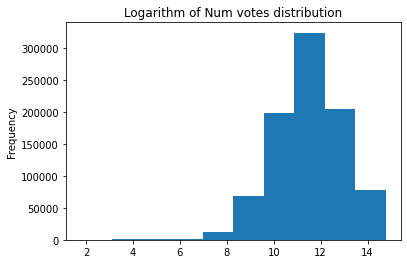

In [37]:
augmented_movielens.logNumVotesMovie.plot.hist(title="Logarithm of Num votes distribution")

In [38]:
augmented_movielens.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,ZipCode,averageRatingMovie,logNumVotesMovie
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,8.7,13.797795
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,6.7,11.096652
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067,7.8,11.452783
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067,7.4,12.173456
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,7.2,12.564953


#### Top directors

We add a feature stating whether top director is involved in a particular film.

In [39]:
augmented_movielens = add_top_directors(augmented_movielens)

In [40]:
augmented_movielens.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,ZipCode,averageRatingMovie,logNumVotesMovie,topDirectorMovie
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,8.7,13.797795,0
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,6.7,11.096652,0
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067,7.8,11.452783,0
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067,7.4,12.173456,0
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,7.2,12.564953,0


## Format data

#### Movies' genres

We further augment the dataset with the movie genre. One movie may have several genres, and the genre is a categorial value, so we make a bitmask for each film, which has 1 if the movie belongs to the corresponding genre.

The augmentation gives us 18 features for the film.

In [41]:
augmented_movielens = encode_bitmask_genres(augmented_movielens)

<AxesSubplot:title={'center':'Genre feature distribution'}>

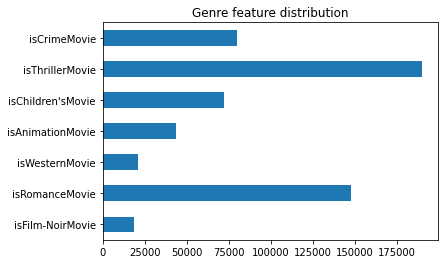

In [42]:
augmented_movielens.loc[:, "isFilm-NoirMovie":].sum(axis=0).plot.barh(title="Genre feature distribution")

In [43]:
augmented_movielens.head()

,UserID,MovieID,Rating,Timestamp,Title,Gender,Age,Occupation,ZipCode,averageRatingMovie,...,isActionMovie,isMysteryMovie,isDramaMovie,isFilm-NoirMovie,isRomanceMovie,isWesternMovie,isAnimationMovie,isChildren'sMovie,isThrillerMovie,isCrimeMovie
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),F,1,10,48067,8.7,...,False,False,True,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),F,1,10,48067,6.7,...,False,False,False,False,False,False,True,True,False,False
2,1,914,3,978301968,My Fair Lady (1964),F,1,10,48067,7.8,...,False,False,False,False,True,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich (2000),F,1,10,48067,7.4,...,False,False,True,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A (1998)",F,1,10,48067,7.2,...,False,False,False,False,False,False,True,True,False,False


#### User ages

Further we go to the user features. First, we encode the age. For some reason, the movielens dataset has only a few unique values for the ages, so we assume they were splitted to several bins. This decision is quite useful for our system, as the dependency between the user age and their preferences is not really linear, so we again just make a bitmask, encoding the user age. For this feature, one user may have only one age value, so it basically becomes one-hot encoding (OHE).

We also add the log value of the user age (just in case :O, there is no such a notion of "too much features").

This augmentation gives us 8 features.

In [44]:
augmented_movielens = encode_ohe_age(augmented_movielens)

<AxesSubplot:title={'center':'Age feature distribution'}>

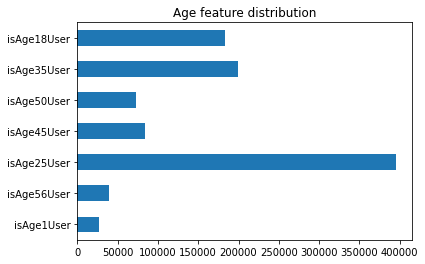

In [45]:
augmented_movielens.iloc[:, -7:].sum(axis=0).plot.barh(title="Age feature distribution")

In [46]:
augmented_movielens.head()

,UserID,MovieID,Rating,Timestamp,Title,Gender,Occupation,ZipCode,averageRatingMovie,logNumVotesMovie,...,isThrillerMovie,isCrimeMovie,logAgeUser,isAge1User,isAge56User,isAge25User,isAge45User,isAge50User,isAge35User,isAge18User
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),F,10,48067,8.7,13.797795,...,False,False,0.0,True,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),F,10,48067,6.7,11.096652,...,False,False,0.0,True,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady (1964),F,10,48067,7.8,11.452783,...,False,False,0.0,True,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich (2000),F,10,48067,7.4,12.173456,...,False,False,0.0,True,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A (1998)",F,10,48067,7.2,12.564953,...,False,False,0.0,True,False,False,False,False,False,False


#### Users' occupation

Next, we encode the occupation of users. Again, a bitmask which is basically OHE.

In [47]:
augmented_movielens = encode_ohe_occupation(augmented_movielens)

<AxesSubplot:title={'center':'Users occupation statistics'}>

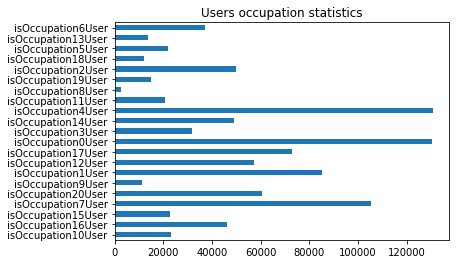

In [48]:
augmented_movielens.loc[:, "isOccupation10User":].sum(axis=0).plot.barh(title="Users occupation statistics")

In [49]:
augmented_movielens.head()

,UserID,MovieID,Rating,Timestamp,Title,Gender,ZipCode,averageRatingMovie,logNumVotesMovie,topDirectorMovie,...,isOccupation14User,isOccupation4User,isOccupation11User,isOccupation8User,isOccupation19User,isOccupation2User,isOccupation18User,isOccupation5User,isOccupation13User,isOccupation6User
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),F,48067,8.7,13.797795,0,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),F,48067,6.7,11.096652,0,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady (1964),F,48067,7.8,11.452783,0,...,False,False,False,False,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich (2000),F,48067,7.4,12.173456,0,...,False,False,False,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A (1998)",F,48067,7.2,12.564953,0,...,False,False,False,False,False,False,False,False,False,False


#### Users' genders

Finally, the gender. We were brave enough to binarize this value.

In [50]:
augmented_movielens = process_gender(augmented_movielens)

In [51]:
print(f"The {round(100 * augmented_movielens.GenderUser.mean(), 1)} of the users self-identify as men")

The 75.4 of the users self-identify as men


In [52]:
augmented_movielens.head()

,UserID,MovieID,Rating,Timestamp,Title,ZipCode,averageRatingMovie,logNumVotesMovie,topDirectorMovie,isComedyMovie,...,isOccupation4User,isOccupation11User,isOccupation8User,isOccupation19User,isOccupation2User,isOccupation18User,isOccupation5User,isOccupation13User,isOccupation6User,GenderUser
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),48067,8.7,13.797795,0,False,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),48067,6.7,11.096652,0,False,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady (1964),48067,7.8,11.452783,0,False,...,False,False,False,False,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich (2000),48067,7.4,12.173456,0,False,...,False,False,False,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A (1998)",48067,7.2,12.564953,0,True,...,False,False,False,False,False,False,False,False,False,False


## Save the preprocessed data

In [53]:
augmented_movielens.to_csv("data/augmented_movie_lens.csv", index=False)